In [1]:
from hossam import load_data
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

from statsmodels.formula.api import ols

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [2]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('cars')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리


===== 데이터 크기 확인 =====
데이터셋 크기 : (50, 2)
열 개수: 2
행 개수: 50

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


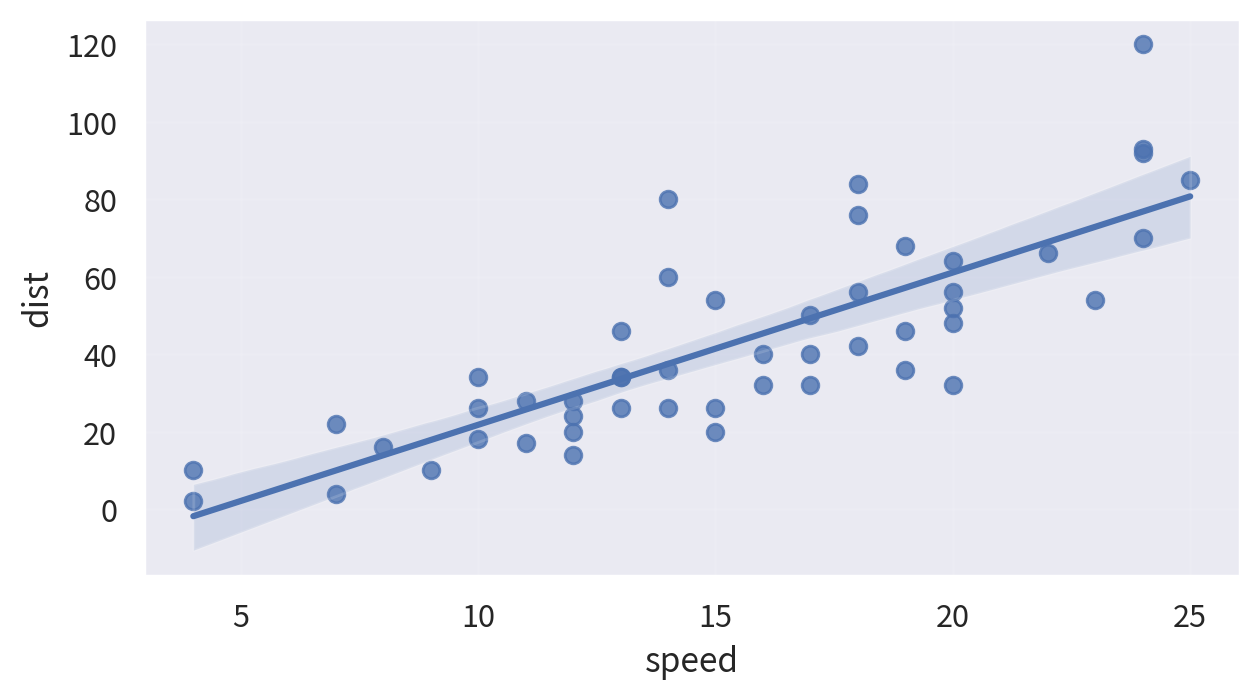

In [4]:
width_px = 1280
height_px = 720
rows=1
cols=1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, dpi=my_dpi, figsize=figsize)

sb.regplot(data=origin, x='speed', y='dist')

ax.grid(True, alpha=0.1)

plt.tight_layout()
plt.show()
plt.close()


=== 이상치 확인 ===
이상치 존재


,original_skew,log_skew,outliers(|z|>3)
speed,-0.117510,-1.668586,0.0
dist,0.806895,-1.384501,1.0


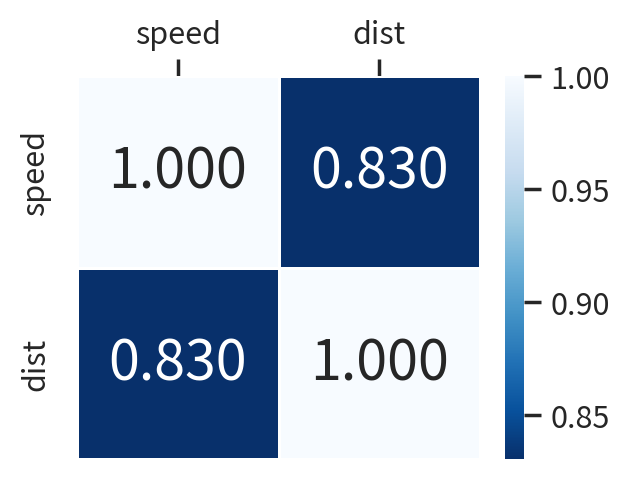

본 분석에서는 speed과 dist간 상관관계를 검토하였다.

데이터 점검 결과, 두 변수의 관계는 비선형 관계 가능성 또는 이상치의 영향이 확인되어 스피어만 상관계수를 사용하였다.

분석 결과, 스피어만 상관계수는 r= 0.830, p=0.000(으)로 나타나 두 변수 간 양의 단조 관계가 존재함을 확인하였다.


In [6]:
xname = 'speed'
yname= 'dist'

linearity_ok = True
data = origin[[xname, yname]]

results = {}

for col in data.columns:
    temp = data[col].dropna()

    skew_original = temp.skew()

    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) >3))

    data_log = np.log1p(temp -temp.min() +1)
    skew_log = data_log.skew()

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count
    }
results_df = DataFrame(results).T

outlier_flag = len(results_df[results_df['outliers(|z|>3)'] >0]) >0

print("\n=== 이상치 확인 ===")
print(f"{'이상치 존재' if outlier_flag else '이상치 존재하지 않음'}")
display(results_df)

report = f"본 분석에서는 {xname}과 {yname}간 상관관계를 검토하였다.\n\n"

if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearsonr(origin[xname],origin[yname])

    if pval > 0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report += f"데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.\n\n분석 결과, 피어슨 상관계수는 r= {corr:0.3f}, p={pval:0.3f}(으)로 나타나 두 변수 간 {"양의 상관" if corr > 0 else "음의 상관"} 관계가 통계적으로 유의함을 확인하였다."
else:
    chosen = 'spearman'
    corr, pval = spearmanr(origin[xname],origin[yname])

    if pval > 0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report += f"데이터 점검 결과, 두 변수의 관계는 비선형 관계 가능성 또는 이상치의 영향이 확인되어 스피어만 상관계수를 사용하였다.\n\n분석 결과, 스피어만 상관계수는 r= {corr:0.3f}, p={pval:0.3f}(으)로 나타나 두 변수 간 {"양의 단조" if corr > 0 else "음의 단조"} 관계가 존재함을 확인하였다."

corr_matrix = origin[[xname, yname]].corr(method=chosen)

width_px = 650
height_px = 500
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.3f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':20})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()

print(report)

행렬기반 선형회귀

In [10]:
# 독립 변수는 DataFrame 형태로 준비
x = origin[['speed']]
x.head()

,speed
0,4
1,4
2,7
3,7
4,8


In [ ]:
# 종속변수는 series 형태로 준비
y = origin['dist']
y.head()

0     2
1    10
2     4
3    22
4    16
Name: dist, dtype: int64

In [11]:
X = sm.add_constant(x)
X.head()

,const,speed
0,1.0,4
1,1.0,4
2,1.0,7
3,1.0,7
4,1.0,8


In [12]:
model = sm.OLS(y, X)
fit = model.fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                   목, 11 12 2025   Prob (F-statistic):           1.49e-12
Time:                        10:58:27   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

formula API 방식

In [13]:
model = ols("dist ~ speed", data=origin)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                   목, 11 12 2025   Prob (F-statistic):           1.49e-12
Time:                        10:58:56   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.5791      6.758     -2.601      0.0

모형 예측값 얻기

In [14]:
df = origin.copy()
df['y_pred'] = fit.predict(X)
df.head()

,speed,dist,y_pred
0,4,2,-1.849460
1,4,10,-1.849460
2,7,4,9.947766
3,7,22,9.947766
4,8,16,13.880175


In [15]:
df_melt = df.melt(
    id_vars="speed",
    value_vars = ["dist", "y_pred"],
    var_name="variable",
    value_name="value"
)
df_melt.head()

,speed,variable,value
0,4,dist,2.0
1,4,dist,10.0
2,7,dist,4.0
3,7,dist,22.0
4,8,dist,16.0


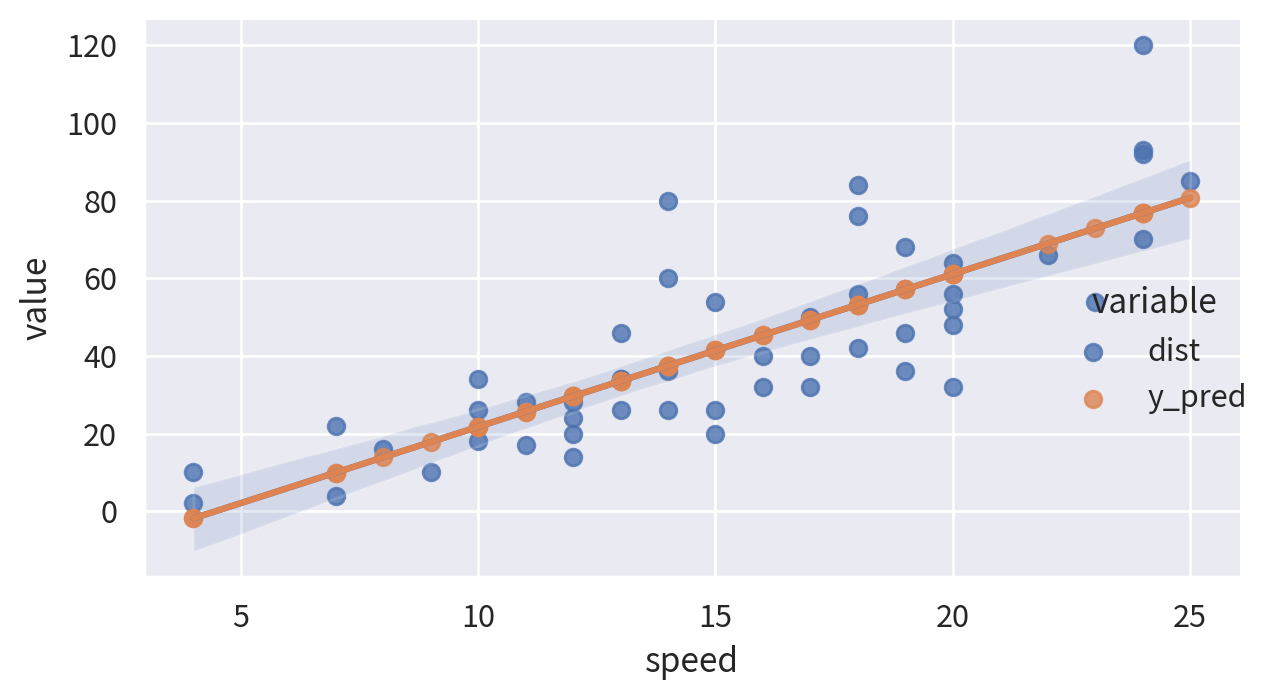

In [16]:
width_px = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)

g = sb.lmplot(data=df_melt, x='speed', y='value', hue="variable")
g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])
plt.grid()

plt.tight_layout()
plt.show()
plt.close()

연습문제1.
- father-son 데이터 셋은 아버지와 아들의 키를 조사한 데이터 셋이다. 아버지의 키가 아들의 키에 영향을 주는지 분석하고 결과를 보고하시오.

In [17]:
origin = load_data('father-son')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab12_/father-son.xlsx
[desc] 아버지와 아들의 키를 조사한 데이터 (출처: https://www.kaggle.com/datasets/aungdev/pearson-dataset-heights-of-fathers-and-their-sons)

field    description
-------  -------------------
fheight  아버지의 키(Inches)
sheight  아들의 키(Inches)


===== 데이터 크기 확인 =====
데이터셋 크기 : (1078, 2)
열 개수: 2
행 개수: 1078

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fheight  1078 non-null   float64
 1   sheight  1078 non-null   float64
dtypes: float64(2)
memory usage: 17.0 KB
None


,fheight,sheight
0,65.04851,59.77827
1,63.25094,63.21404
2,64.95532,63.34242
3,65.75250,62.79238
4,61.13723,64.28113


In [26]:
x = origin[['fheight']]
x.head()

,fheight
0,65.04851
1,63.25094
2,64.95532
3,65.75250
4,61.13723


In [27]:
y = origin['sheight']
y.head()

0    59.77827
1    63.21404
2    63.34242
3    62.79238
4    64.28113
Name: sheight, dtype: float64

In [28]:
X = sm.add_constant(x)
model = sm.OLS(y, X)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                sheight   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     361.2
Date:                   목, 11 12 2025   Prob (F-statistic):           1.12e-69
Time:                        11:51:47   Log-Likelihood:                -2488.7
No. Observations:                1078   AIC:                             4981.
Df Residuals:                    1076   BIC:                             4991.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.8866      1.832     18.493      0.0

In [25]:
model = ols('sheight ~ fheight', data=origin)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                sheight   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     361.2
Date:                   목, 11 12 2025   Prob (F-statistic):           1.12e-69
Time:                        11:49:47   Log-Likelihood:                -2488.7
No. Observations:                1078   AIC:                             4981.
Df Residuals:                    1076   BIC:                             4991.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.8866      1.832     18.493      0.0

#### 모형 적합도 보고
>sheight를 종속변수로, fheight를 독립변수로 한 단순회귀분석 결과, 모형은 통계적으로 유의하였다.
>
>F(1,1076) = 361.2, p<0.05, R^2 = 0.251
>
>즉, fheight는 sheight의 약 25.1%를 설명하는 것으로 나타났다.

#### 독립변수 보고
>독립변수가 종속변수에 유의미한 영향을 주는지 보고하기 위해 회귀계수(B), t값, 자유도(df), p-value을 기술한다.
>
> 독립변수 유의성 : B= 0.5141로 나타났으며, 이는 아들의 키에 유의한 요인임을 의미한다.
>
> t(1076) = 19.01, p<0.001
>
> 즉, 아버지의 키가 1 단위 증가할 때 아들의 키는 평균 0.51정도 증가하는 것으로 해석된다.

- 아들키 = 0.5141 x 아빠 키 +33.8

In [22]:
df = origin.copy()
df['y_pred'] = fit.predict(X)
df.head()

,fheight,sheight,y_pred
0,65.04851,59.77827,63.333051
1,63.25094,63.21404,65.012799
2,64.95532,63.34242,65.075564
3,65.75250,62.79238,64.806650
4,61.13723,64.28113,65.534500


In [23]:
df_melt = df.melt(
    id_vars="sheight",
    value_vars = ["fheight", "y_pred"],
    var_name="variable",
    value_name="value"
)
df_melt.head()

,sheight,variable,value
0,59.77827,fheight,65.04851
1,63.21404,fheight,63.25094
2,63.34242,fheight,64.95532
3,62.79238,fheight,65.75250
4,64.28113,fheight,61.13723


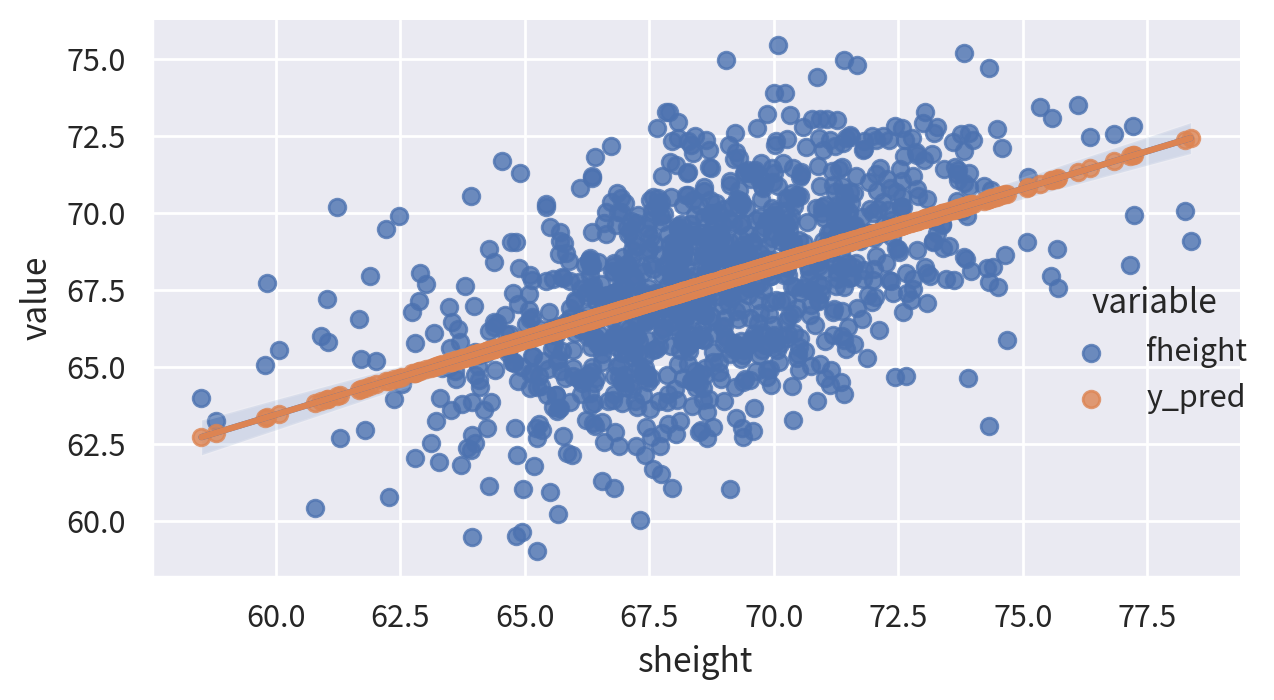

In [29]:
width_px = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)

g = sb.lmplot(data=df_melt, x='sheight', y='value', hue="variable")
g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])
plt.grid()

plt.tight_layout()
plt.show()
plt.close()